In [1]:
# Import the necessary packages
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Suppress specific future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import the clean data
data = pd.read_pickle('source\data.pkl')

data.info()

# Copy of the original dataset for feature engineering and preprocessing
data_processed = data.copy()

# Drop unnecessary columns
data_processed = data_processed.drop(['AccID', 'birth_year', 'vehicleID', 'num_veh'], axis=1)

# Convert 'day', 'month', and 'time' to integers
data_processed['day'] = data_processed['day'].astype(int)
data_processed['month'] = data_processed['month'].astype(int)
data_processed['time'] = data_processed['time'].astype(int)

# Cyclical encoding for temporal features
data_processed['day_sin'] = np.sin(2 * np.pi * data_processed['day'] / 31)  
data_processed['day_cos'] = np.cos(2 * np.pi * data_processed['day'] / 31)

data_processed['month_sin'] = np.sin(2 * np.pi * data_processed['month'] / 12)
data_processed['month_cos'] = np.cos(2 * np.pi * data_processed['month'] / 12)

data_processed['time_sin'] = np.sin(2 * np.pi * data_processed['time'] / 86340000) 
data_processed['time_cos'] = np.cos(2 * np.pi * data_processed['time'] / 86340000)

data_processed.drop(columns=['day','month','time'],inplace=True)

# Selecting features and target variable
features_dummy = ['year', 'lum', 'atm_condition', 'collision_type',
       'route_category', 'traffic_regime', 'total_number_lanes',
       'reserved_lane_code', 'longitudinal_profile', 'plan',
       'surface_condition', 'infra', 'accident_situation',
       'traffic_direction', 'vehicle_category', 'fixed_obstacle',
       'mobile_obstacle', 'initial_impact_point', 'manv', 'motor', 'seat',
       'user_category', 'gender', 'reason_travel',
       'safety_equipment1']

# These features will be standardized
features_scaler = ['lat', 'long', 'upstream_terminal_number', 'distance_upstream_terminal', 'maximum_speed', 'age']

# These features are between -1 and 1 and do not need any standardazations. 
features_temporal = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'time_sin', 'time_cos']
target = 'gravity'

X = data_processed.drop(columns=[target])
y = data_processed[target]
y = y.astype(int)

X = pd.get_dummies(X, columns=features_dummy, drop_first=True)

# stratify will split the dataset according to the distribution of the classes to compensate for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardization: Fit only on the training data, then apply to both train and test
scaler = StandardScaler()
X_train[features_scaler] = scaler.fit_transform(X_train[features_scaler])
X_test[features_scaler] = scaler.transform(X_test[features_scaler])

# Check the dimensions
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447670 entries, 0 to 447669
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AccID                       447670 non-null  object 
 1   day                         447670 non-null  object 
 2   month                       447670 non-null  object 
 3   year                        447670 non-null  object 
 4   time                        447670 non-null  object 
 5   lum                         447670 non-null  object 
 6   atm_condition               447670 non-null  object 
 7   collision_type              447670 non-null  object 
 8   lat                         447670 non-null  float64
 9   long                        447670 non-null  float64
 10  route_category              447670 non-null  object 
 11  traffic_regime              447670 non-null  object 
 12  total_number_lanes          447670 non-null  object 
 13  reserved_lane_

Apply ML v7--------> SMOTE + ENN 

In [2]:
# Applying the XGBoost model on the preprocessed data, assuming the initial preprocessing code was already executed


# Modify the target variable 'gravity' to have two classes: 1 (Fatal) and 0 (Non-Fatal)
# 2 -> Fatal, 1/3/4 -> Non-Fatal
y_train = y_train.replace({2: 1, 1: 0, 3: 0, 4: 0})
y_test = y_test.replace({2: 1, 1: 0, 3: 0, 4: 0})


In [3]:
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report
import xgboost as xgb

# Initialize SMOTE + ENN with a random state for reproducibility
smote_enn = SMOTEENN(random_state=42)

# Apply SMOTE + ENN to the training set
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

# Initialize and train the XGBoost model with the best parameters found in previous tuning
xgb_model_smote_enn = xgb.XGBClassifier(
    n_estimators=400, 
    max_depth=4, 
    learning_rate=0.3, 
    subsample=0.7, 
    colsample_bytree=0.8, 
    gamma=0.1, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_model_smote_enn.fit(X_train_smote_enn, y_train_smote_enn)

# Make predictions on the test set
y_pred_smote_enn = xgb_model_smote_enn.predict(X_test)

# Generate and print the classification report
classification_report_output_smote_enn = classification_report(y_test, y_pred_smote_enn, target_names=["Non-Fatal", "Fatal"])
print("SMOTE + ENN Report:")
print(classification_report_output_smote_enn)


C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


SMOTE + ENN Report:
              precision    recall  f1-score   support

   Non-Fatal       0.98      0.97      0.98     87278
       Fatal       0.24      0.34      0.28      2256

    accuracy                           0.96     89534
   macro avg       0.61      0.66      0.63     89534
weighted avg       0.96      0.96      0.96     89534



--------> LIME

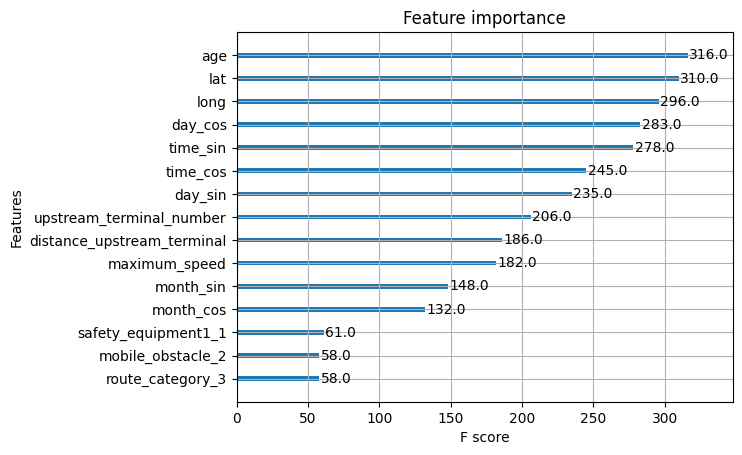

In [8]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance using the already trained model
plot_importance(xgb_model_smote_enn, max_num_features=15)  
plt.show()

In [6]:
import lime
import lime.lime_tabular
import numpy as np

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns,
    class_names=["Non-Fatal", "Fatal"], 
    mode='classification'
)

# Choose an instance to explain (e.g., the first instance in the test set)
instance_index = 0
instance = X_test.iloc[instance_index].values.reshape(1, -1)

# Generate explanation for the chosen instance
exp = explainer.explain_instance(
    X_test.iloc[instance_index], 
    xgb_model_smote_enn.predict_proba
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)


--------> SHAP

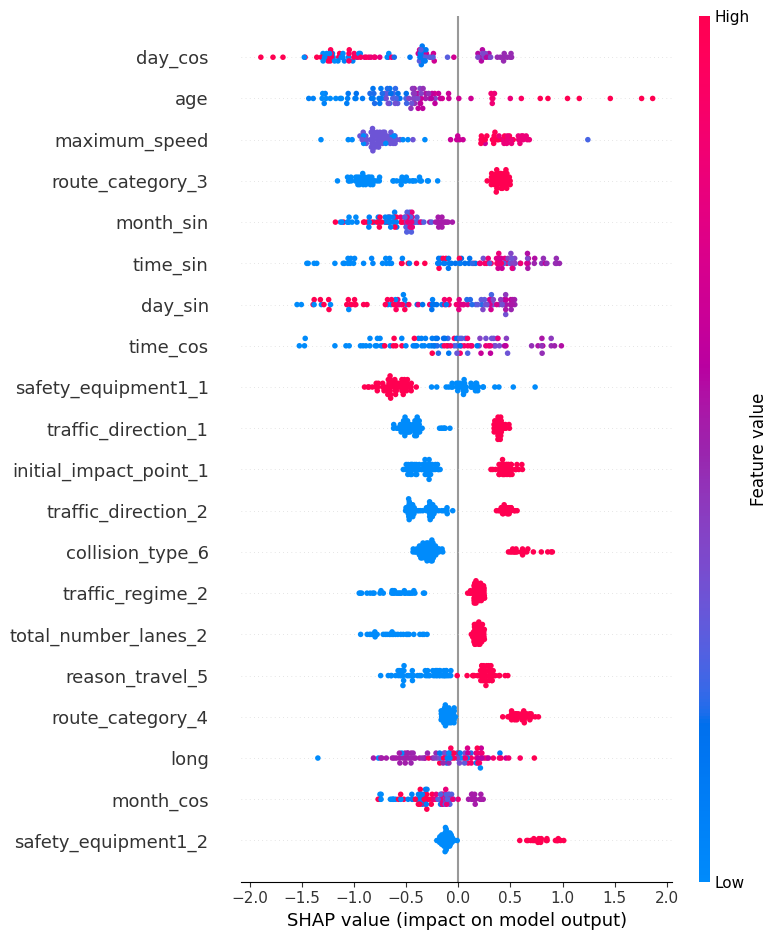

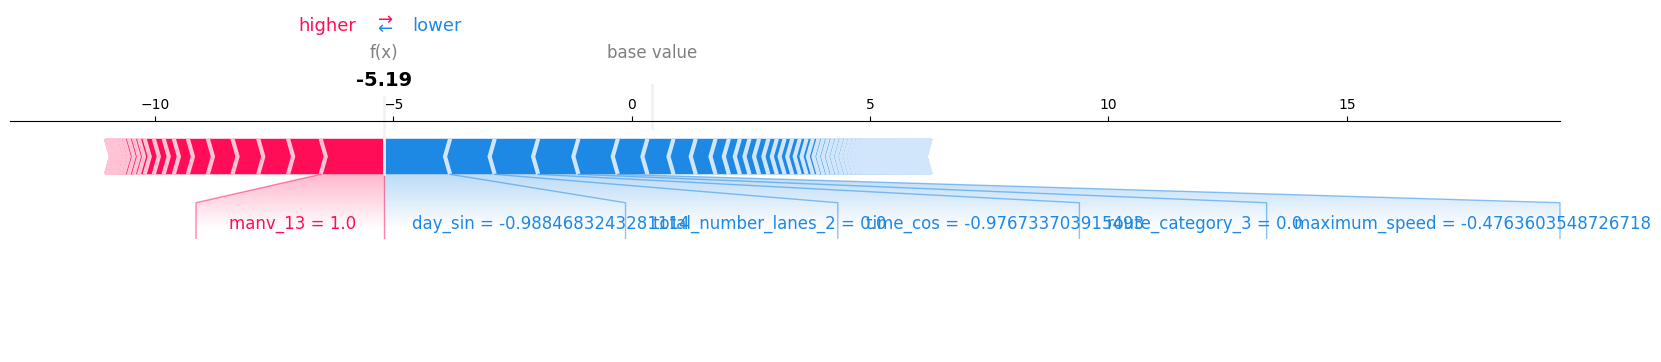

In [7]:
import shap

# Create a SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model_smote_enn)

# Calculate SHAP values for a subset of the test set to reduce computation time
X_test_sample = X_test.sample(100, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Plot summary plot for feature importance
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test.columns)

# Plot SHAP values for a single prediction (e.g., the first instance in the sample)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_sample.iloc[0, :], matplotlib=True)


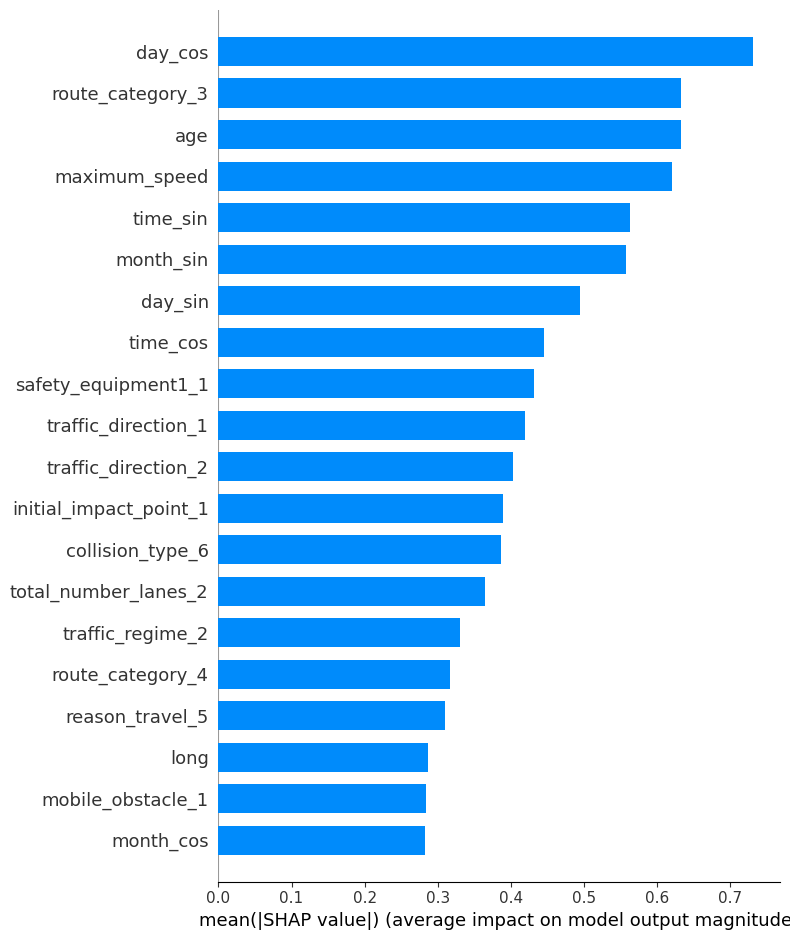

In [9]:
import shap

# Initialize the SHAP explainer using the trained model
explainer = shap.TreeExplainer(xgb_model_smote_enn)
shap_values = explainer.shap_values(X_test)

# Summary plot for feature importance (global interpretability)
shap.summary_plot(shap_values, X_test, plot_type="bar")

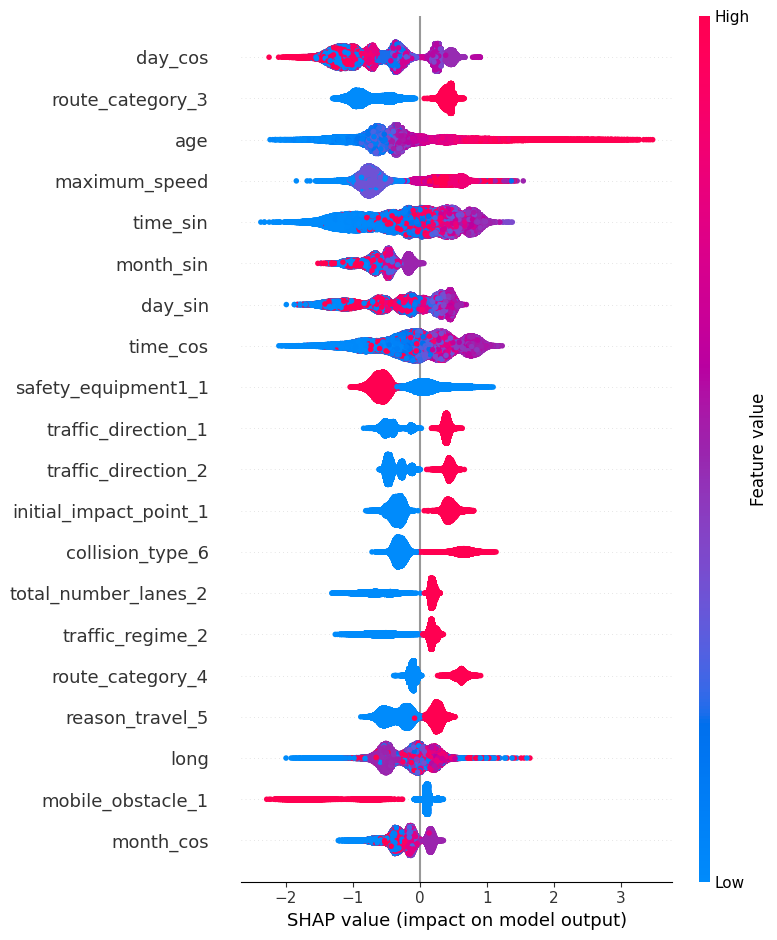

In [10]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_model_smote_enn)

# Calculate SHAP values for the entire dataset (this handles multiclass automatically)
shap_values = explainer(X_test)

# Use SHAP's internal handling to create the summary plot
shap.summary_plot(shap_values, X_test, plot_type="dot")


Dependence plot for day_cos:


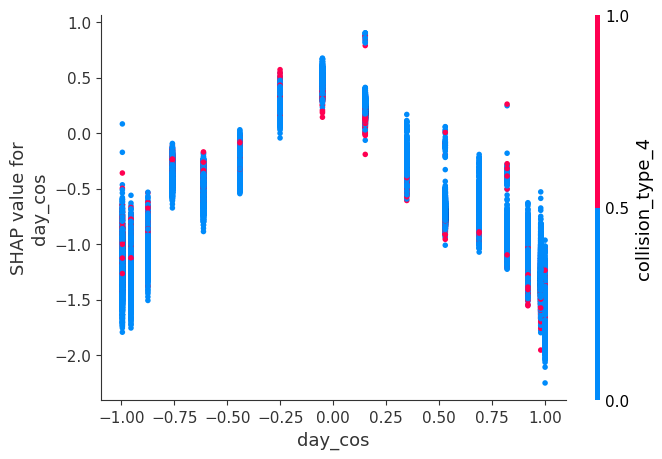

Dependence plot for maximum_speed:


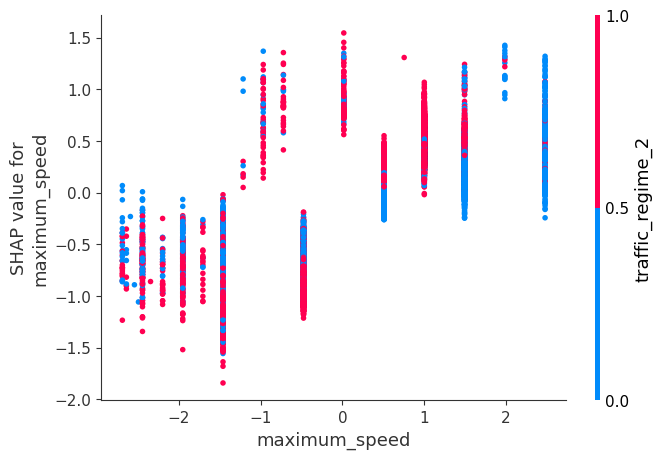

Dependence plot for age:


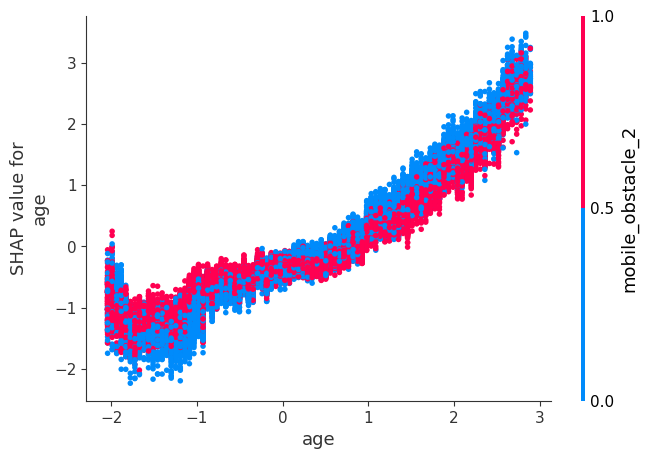

In [11]:
import shap

# Initialize the SHAP explainer if not already done
explainer = shap.TreeExplainer(xgb_model_smote_enn)

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# List of feature names for which you'd like to display dependence plots
features_to_plot = ['day_cos', 'maximum_speed', 'age']  

# Generate dependence plots for each feature
for feature in features_to_plot:
    print(f"Dependence plot for {feature}:")
    shap.dependence_plot(feature, shap_values, X_test)